Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Digital Music
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
# importa dataset 'amazon digital music'
data = pd.read_csv("../datasets/Digital_Music.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Digital_Music'
user_col = 'user_id'

In [4]:
data.shape

(1584082, 4)

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

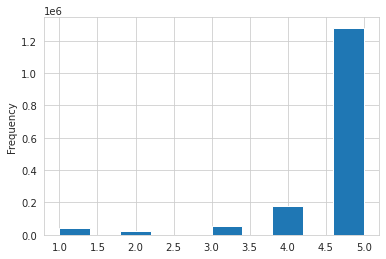

In [6]:
data['rating'].plot(kind='hist')

In [7]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [8]:
pos_ratings

5.0

In [9]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [10]:
# number of remaining cases
data.shape[0]

1280147

### Convert timestamp

In [11]:
%%time
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 1.64 s, sys: 119 ms, total: 1.76 s
Wall time: 1.76 s


In [12]:
data.head()

,user_id,item_id,timestamp,date
2092,9714721180,A2SY49Z6H96QVR,877305600,1997-10-20
147526,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-28
83632,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-28
54105,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-22
117999,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-22


In [13]:
data.tail()

,user_id,item_id,timestamp,date
1579530,B01GPDFR26,A312L5Z8SW61FR,1538265600,2018-09-30
1577166,B01G7OH4KG,A1UACDAXDOWB2H,1538265600,2018-09-30
1576589,B01G4DH4AU,A7O6RHCU9RZ8L,1538352000,2018-10-01
1582372,B01H7XADLS,A1X087SYY8ZFGC,1538438400,2018-10-02
1584000,B01HJ91MF6,A2W9IUJUFHKD40,1538438400,2018-10-02


In [14]:
%%time
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: user 15.1 s, sys: 253 ms, total: 15.3 s
Wall time: 15.3 s


## Evaluating Time defined Buckets 

Sampling the dataset

In [15]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 634 ms, sys: 15.9 ms, total: 650 ms
Wall time: 643 ms


<AxesSubplot:xlabel='date'>

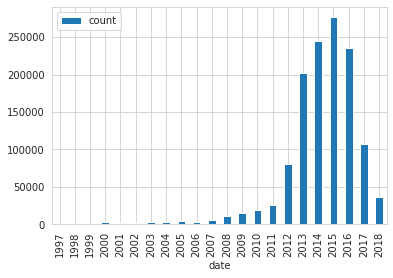

In [16]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar')

In [17]:
y_filter = (data['date'] < datetime.strptime('2014-04', '%Y-%m')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 

In [18]:
data = data[y_filter]

In [19]:
# number of remaining cases
data.shape[0]

53575

Sampling the dataset - only most frequent users (overall)

In [20]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 73.6 ms, sys: 4.21 ms, total: 77.8 ms
Wall time: 76.7 ms


<AxesSubplot:ylabel='Frequency'>

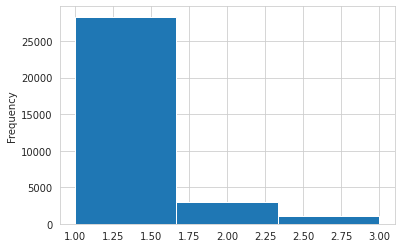

In [21]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [22]:
# # we'll filter users with frequency higher than q
# threshold = np.quantile(user_freq_over_months, q=0.5)
# threshold

In [23]:
# # there are this many users with freq above the threshold
# (user_freq_over_months >= threshold).sum()

In [24]:
# # index of frequent users
# freq_users = user_freq_over_months[user_freq_over_months >= threshold].index

In [25]:
# # sample the dataset to contain only interactions from frequent users (that occur every month).
# # there is still a huge number of interactions - 1694351
# _ = data.set_index('user_id').loc[freq_users]
# _.shape
_ = data.set_index('user_id').copy()

<AxesSubplot:>

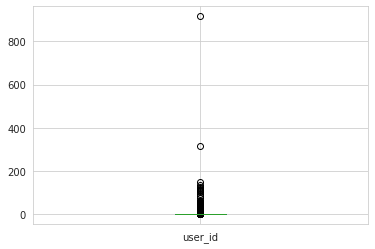

In [26]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [27]:
u = data['user_id'].value_counts().reset_index()['index'].to_list()

In [28]:
# to user, or not to use p ?
p = (data['user_id'].value_counts()/data['user_id'].shape[0])

In [29]:
prop = 1
s = round( len( u )*prop )

In [30]:
np.random.seed(42)
sampled_users = list( np.random.choice(u, size=s, replace=False, p=p) ) # , p=p

In [31]:
_.loc[sampled_users]

,item_id,timestamp,date
user_id,,,
B00137RGS8,ASNK93LTU468M,1388707200,2014-01-01
B00137RGS8,A3O4ONI0UWE3HQ,1391040000,2014-01-01
B00137RGS8,A1QE5DD7SIM7MI,1392163200,2014-02-01
B0030Y1WQY,A150ZY4L9DKCWX,1393459200,2014-02-01
B0051U6YUY,A25E0UPCV3MRDS,1392422400,2014-02-01
...,...,...,...
B004WT35P2,A2L5SWPL1S97KW,1392940800,2014-02-01
B000TRTNL6,A2LMBWIR93Q68R,1394668800,2014-03-01
B004LF1CKW,A2LGSXAHK4OO8E,1390867200,2014-01-01


In [32]:
_.loc[sampled_users]['item_id'].nunique()

38248

<AxesSubplot:>

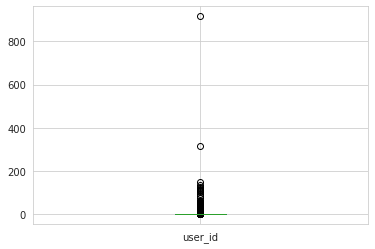

In [33]:
# frequency of users:
_.loc[sampled_users].reset_index()['user_id'].value_counts().plot(kind='box')

CPU times: user 202 ms, sys: 7.17 ms, total: 209 ms
Wall time: 205 ms


<AxesSubplot:ylabel='Frequency'>

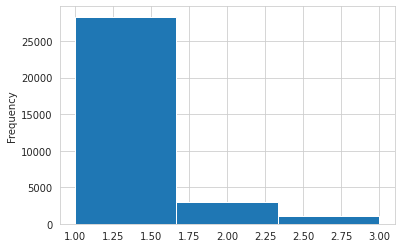

In [34]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
user_freq_over_months_sample.plot(kind='hist',bins=user_freq_over_months_sample.max())

In [35]:
# np.quantile(_.reset_index()['user_id'].value_counts(), 0.9)

In [36]:
# # nu = int( _.reset_index()['user_id'].nunique()*0.0025 ) # 0.05% of users
# threshold = np.quantile(_.reset_index()['user_id'].value_counts(), 0.9) #_.reset_index()['user_id'].value_counts().iloc[:nu].min() # sample 5% of users with highest freq, this freq is the threshold
# freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [37]:
# _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ]

In [38]:
data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

(32378, 38248)

In [39]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items
_.loc[sampled_users].reset_index()['user_id'].nunique(), _.loc[sampled_users].reset_index()['item_id'].nunique() # sample number of users, and of items

(32378, 38248)

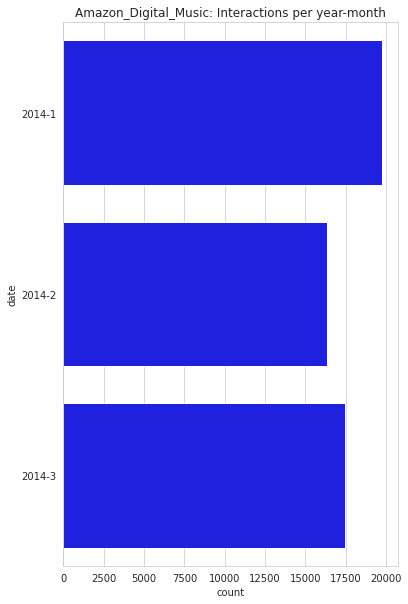

In [40]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [41]:
# previous (huge) sample
# data = data.set_index('user_id').loc[freq_users].reset_index()
# new sample - only 500 most frequent users, from users that occur in every month
# data = _.loc[freq_users].reset_index()
data = _.loc[sampled_users].reset_index()
data = data.sort_values(by='timestamp')

In [42]:
# number of remaining cases
data.shape[0]

53575

In [43]:
# new sample
data.to_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic.csv', index=False)

How many interactions occur in each month / year?

In [44]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 191 ms, sys: 3.87 ms, total: 195 ms
Wall time: 194 ms


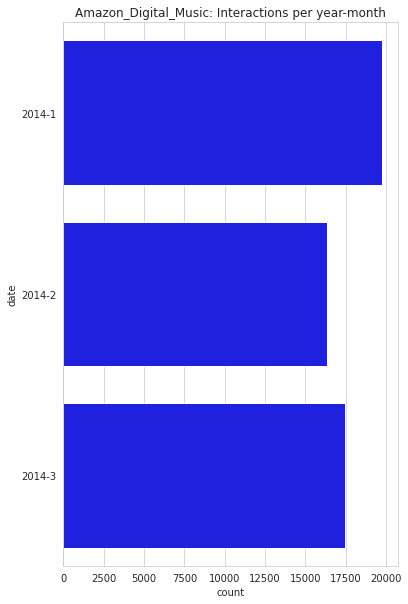

In [45]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [46]:
%%time
# 3min 16s
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# new sample
user_presence_df.to_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv', index=False)

0.0 %
50.0 %
CPU times: user 7min 56s, sys: 203 ms, total: 7min 56s
Wall time: 7min 56s


In [47]:
user_presence_df.head()

,UserID,month_%
0,B00EQO0GB4,1.0
1,B00136RVG6,1.0
2,B001O3UEOE,1.0
3,B00HW0J51Q,1.0
4,B001OFZRXA,1.0


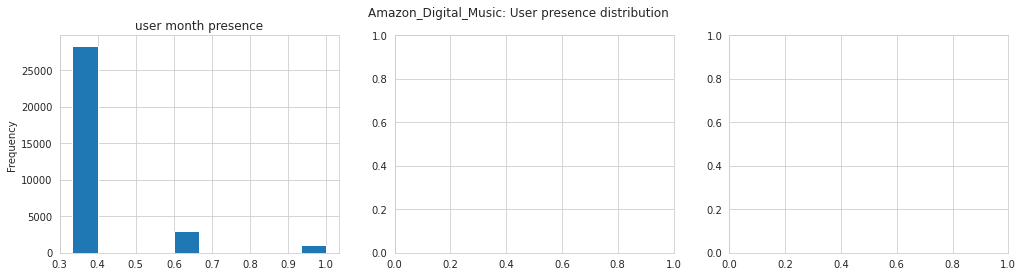

In [48]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [49]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [50]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [51]:
# defining threshold
frequency_threshold = 0.0

In [52]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

32378 users of 32378 (100.0%) occurr in 0.0% or more months.


In [53]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/amazon_digmusic_dump/sample_frequent_users_month.joblib')

['output/amazon_digmusic_dump/sample_frequent_users_month.joblib']